In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer, make_moons
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold

import matplotlib.pyplot as plt
import time
from sklearn.model_selection import KFold
import shap

from decision_tree import DecisionTree, compute_metrics, k_fold_cross_validation

C:\Users\Lance\Documents\Homework\CS470\HW3\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Visualize decision boundaries
def plot_decision_boundary(model, X, y, title, ax):
    # Set min and max values with some padding
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    
    # Create a mesh grid
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    
    # Make predictions on the mesh grid
    if hasattr(model, 'predict'):
        if model.__class__.__name__ == 'DecisionTree':  # Custom model
            mesh_df = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], 
                                  columns=['Feature 1', 'Feature 2'])
            Z = model.predict(mesh_df)
        else:  # Scikit-learn model
            Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
    
    # Plot the decision boundary
    ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdBu)
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu_r, edgecolor='k')
    ax.set_title(title)
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')



--- Moons Dataset Comparison (Nonlinear Binary Classification) ---
Custom Tree Accuracy: 0.8700
Scikit-learn Tree Accuracy: 0.8850


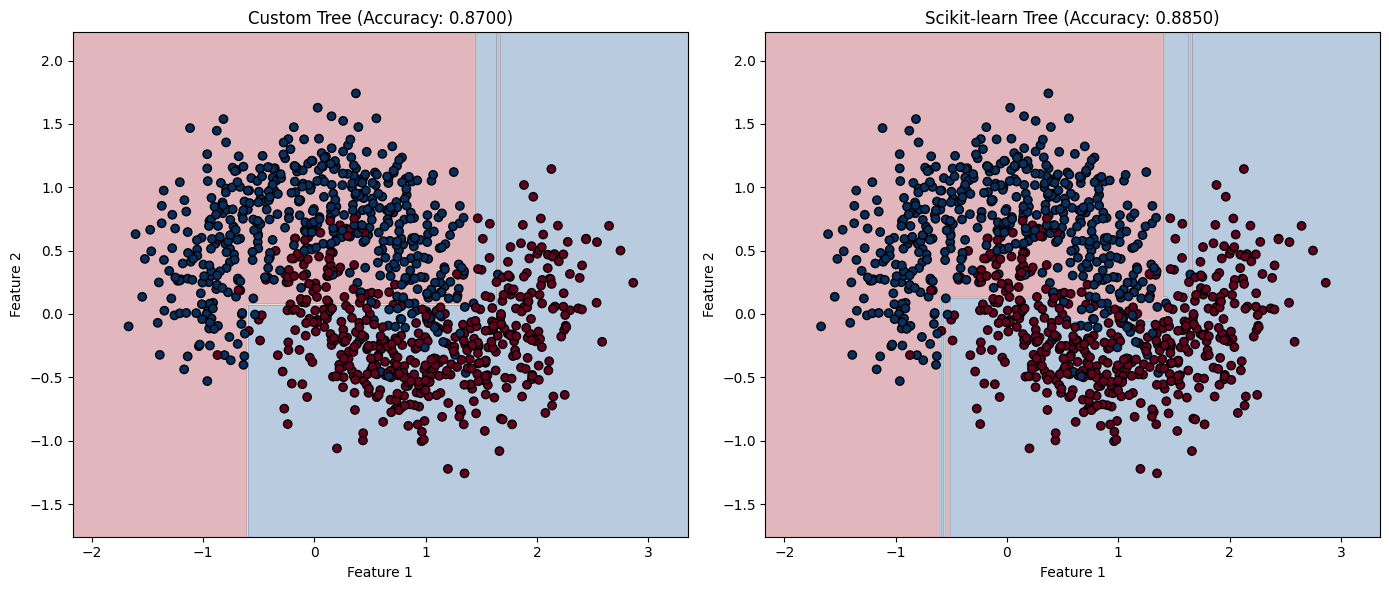

In [3]:
# Try another binary dataset for comparison
from sklearn.datasets import make_moons

# Create a more challenging dataset
X, y = make_moons(n_samples=1000, noise=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to DataFrame for your custom tree
X_train_df = pd.DataFrame(X_train, columns=['Feature 1', 'Feature 2'])
X_test_df = pd.DataFrame(X_test, columns=['Feature 1', 'Feature 2'])

print("\n\n--- Moons Dataset Comparison (Nonlinear Binary Classification) ---")

# Custom tree
custom_tree = DecisionTree(max_depth=5)
custom_tree.fit(X_train_df, y_train)
custom_pred = custom_tree.predict(X_test_df)
custom_accuracy = accuracy_score(y_test, custom_pred)

# Scikit-learn tree
sklearn_tree = DecisionTreeClassifier(max_depth=5, random_state=42)
sklearn_tree.fit(X_train, y_train)
sklearn_pred = sklearn_tree.predict(X_test)
sklearn_accuracy = accuracy_score(y_test, sklearn_pred)

print(f"Custom Tree Accuracy: {custom_accuracy:.4f}")
print(f"Scikit-learn Tree Accuracy: {sklearn_accuracy:.4f}")

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot decision boundaries
plot_decision_boundary(custom_tree, X, y, f'Custom Tree (Accuracy: {custom_accuracy:.4f})', ax1)
plot_decision_boundary(sklearn_tree, X, y, f'Scikit-learn Tree (Accuracy: {sklearn_accuracy:.4f})', ax2)

plt.tight_layout()
plt.savefig('decision_boundaries.png')
plt.show()

# Data.csv Testing

In [4]:
df = pd.read_csv("data.csv")

In [5]:
label_mappings = {}
categorical_cols = [
    "gender",
    "chest pain type", 
    "fasting blood sugar > 120 mg/dl", 
    "resting electrocardiographic results",
    "exercise induced angina",
    "Has heart disease? (Prediction Target)"
]
encoded_df = df.copy()

for col in categorical_cols:
    encoder = LabelEncoder()
    encoded_df[col] = encoder.fit_transform(encoded_df[col])
    label_mappings[col] = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))

encoded_df = pd.get_dummies(encoded_df, columns=["chest pain type", "resting electrocardiographic results"])

# Integers for one-hot encoding
dummy_columns = [col for col in encoded_df.columns if col.startswith("chest pain type_") or col.startswith("resting electrocardiographic results_")]
encoded_df[dummy_columns] = encoded_df[dummy_columns].astype(int)

In [6]:
df.head()

,person ID,age,gender,chest pain type,resting blood pressure,serum cholesterol in mg/dl,fasting blood sugar > 120 mg/dl,resting electrocardiographic results,maximum heart rate achieved,exercise induced angina,oldpeak = ST depression induced by exercise relative to rest,the slope of the peak exercise ST segment,number of major vessels (0-3) colored by flourosopy,Has heart disease? (Prediction Target)
0,1,63,M,Type 3,145,233,Yes,hypertrophy of heart,150,No,2.3,0,0,Yes
1,2,37,M,Type 2,130,250,No,myocardial infarction,187,No,3.5,0,0,Yes
2,3,41,F,Type 1,130,204,No,hypertrophy of heart,172,No,1.4,2,0,Yes
3,4,56,M,Type 1,120,236,No,myocardial infarction,178,No,0.8,2,0,Yes
4,5,57,F,Type 0,120,354,No,myocardial infarction,163,Yes,0.6,2,0,Yes


In [7]:
encoded_df.head()

,person ID,age,gender,resting blood pressure,serum cholesterol in mg/dl,fasting blood sugar > 120 mg/dl,maximum heart rate achieved,exercise induced angina,oldpeak = ST depression induced by exercise relative to rest,the slope of the peak exercise ST segment,number of major vessels (0-3) colored by flourosopy,Has heart disease? (Prediction Target),chest pain type_0,chest pain type_1,chest pain type_2,chest pain type_3,resting electrocardiographic results_0,resting electrocardiographic results_1,resting electrocardiographic results_2
0,1,63,1,145,233,1,150,0,2.3,0,0,1,0,0,0,1,1,0,0
1,2,37,1,130,250,0,187,0,3.5,0,0,1,0,0,1,0,0,0,1
2,3,41,0,130,204,0,172,0,1.4,2,0,1,0,1,0,0,1,0,0
3,4,56,1,120,236,0,178,0,0.8,2,0,1,0,1,0,0,0,0,1
4,5,57,0,120,354,0,163,1,0.6,2,0,1,1,0,0,0,0,0,1


In [8]:
X_ID = encoded_df.drop(["Has heart disease? (Prediction Target)"], axis=1)
X_no_ID = X_ID.drop(["person ID"], axis=1)
y = encoded_df["Has heart disease? (Prediction Target)"]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_ID, y, test_size=0.2, random_state=42)

train_IDs = X_train["person ID"]
test_IDs = X_test["person ID"]

X_train = X_train.drop(["person ID"], axis=1)
X_test = X_test.drop(["person ID"], axis=1)

In [10]:
train_IDs.to_csv("para2_file.txt")
test_IDs.to_csv("para3_file.txt")

In [11]:
print(X_train.shape)
X_train.head()

(242, 17)


,age,gender,resting blood pressure,serum cholesterol in mg/dl,fasting blood sugar > 120 mg/dl,maximum heart rate achieved,exercise induced angina,oldpeak = ST depression induced by exercise relative to rest,the slope of the peak exercise ST segment,number of major vessels (0-3) colored by flourosopy,chest pain type_0,chest pain type_1,chest pain type_2,chest pain type_3,resting electrocardiographic results_0,resting electrocardiographic results_1,resting electrocardiographic results_2
132,42,1,120,295,0,162,0,0.0,2,0,0,1,0,0,0,0,1
202,58,1,150,270,0,111,1,0.8,2,0,1,0,0,0,1,0,0
196,46,1,150,231,0,147,0,3.6,1,0,0,0,1,0,0,0,1
75,55,0,135,250,0,161,0,1.4,1,0,0,1,0,0,1,0,0
176,60,1,117,230,1,160,1,1.4,2,2,1,0,0,0,0,0,1


In [12]:
myTree = DecisionTree(
    max_depth=8,
    min_samples_split=2,
    criterion="gini"
)
myTree.fit(X_train, y_train)


myPreds = myTree.predict(X_test)
myAccuracy = accuracy_score(y_test, myPreds)
print(f"My accuracy: {myAccuracy}")

myRecall = recall_score(y_test, myPreds)
print(f"My recall: {myRecall}")

print(f"My f1: {f1_score(y_test, myPreds)}")
 

My accuracy: 0.819672131147541
My recall: 0.75
My f1: 0.8135593220338984


In [13]:
skTree = DecisionTreeClassifier(random_state=42)
skTree.fit(X_train, y_train)


skPreds = skTree.predict(X_test)
skAccuracy = accuracy_score(y_test, skPreds)
print(f"Sklearn accuracy: {skAccuracy}")

skRecall = recall_score(y_test, skPreds)
print(f"Sklearn recall: {skRecall}")

Sklearn accuracy: 0.7704918032786885
Sklearn recall: 0.6875


In [14]:
tree = DecisionTree(max_depth=5, min_samples_split=2, criterion="entropy")

metrics = k_fold_cross_validation(tree, X_no_ID, y, k=10)

In [15]:
for metric in ["accuracy", "precision", "recall", "specificity", "f1", "f2"]:
    print(f"Average {metric}: {np.mean(metrics[metric]): .4f}")

Average accuracy:  0.7820
Average precision:  0.7839
Average recall:  0.8368
Average specificity:  0.7181
Average f1:  0.8056
Average f2:  0.8231


Testing criterion: entropy
--------
Average Evaluation Metrics for entropy:
Accuracy: 0.7718
Precision: 0.7613
Recall: 0.8544
Specificity: 0.6742
F1 Score: 0.8013
F2 Score: 0.8312
Testing criterion: gini
--------
Average Evaluation Metrics for gini:
Accuracy: 0.7883
Precision: 0.7776
Recall: 0.8533
Specificity: 0.7099
F1 Score: 0.8113
F2 Score: 0.8354
Testing criterion: gain_ratio
--------
Average Evaluation Metrics for gain_ratio:
Accuracy: 0.7586
Precision: 0.7356
Recall: 0.8717
Specificity: 0.6236
F1 Score: 0.7955
F2 Score: 0.8388


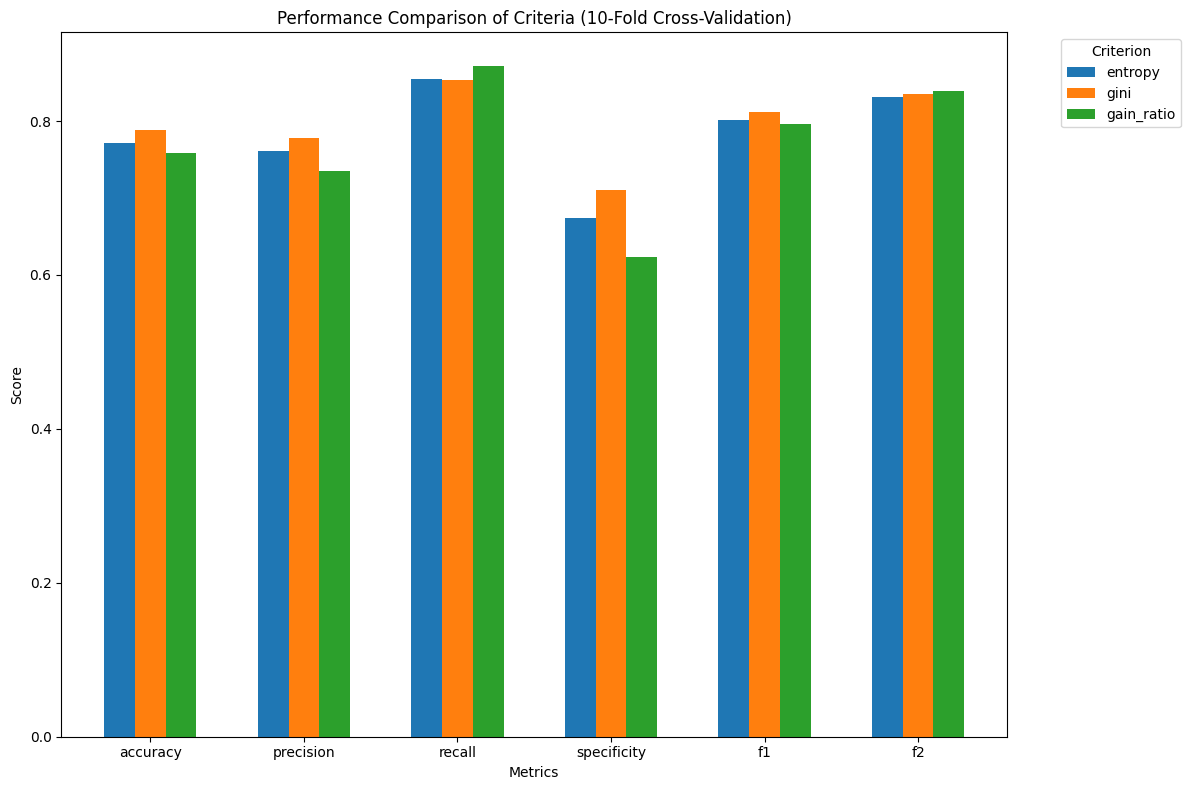

In [16]:
criteria = ["entropy", "gini", "gain_ratio"]
results = {"criterion": [], "accuracy": [], "precision": [], "recall": [], "specificity": [], "f1": [], "f2": []}


ns = 10
cv = StratifiedKFold(n_splits=10)

for criterion in criteria:
    print(f"Testing criterion: {criterion}")
    model = DecisionTree(max_depth=5, min_samples_split=2, criterion=criterion)
    
    accuracies = []
    precisions = []
    recalls = []
    specificities = []
    f1_scores = []
    f2_scores = []
    
    # CV
    for train_index, test_index in cv.split(X_no_ID, y):
        X_cv_train, X_cv_test = X_no_ID.iloc[train_index], X_no_ID.iloc[test_index]
        y_cv_train, y_cv_test = y.iloc[train_index], y.iloc[test_index]
        
        model.fit(X_cv_train, y_cv_train)
        predictions = model.predict(X_cv_test)
        accuracy, precision, recall, specificity, f1, f2 = compute_metrics(y_cv_test, predictions)

        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        specificities.append(specificity)
        f1_scores.append(f1)
        f2_scores.append(f2)
    
    results["criterion"].append(criterion)
    results["accuracy"].append(np.mean(accuracies))
    results["precision"].append(np.mean(precisions))
    results["recall"].append(np.mean(recalls))
    results["specificity"].append(np.mean(specificities))
    results["f1"].append(np.mean(f1_scores))
    results["f2"].append(np.mean(f2_scores))

    print(f"--------\nAverage Evaluation Metrics for {criterion}:\n"
          f"Accuracy: {np.mean(accuracies):.4f}\n"
          f"Precision: {np.mean(precisions):.4f}\n"
          f"Recall: {np.mean(recalls):.4f}\n"
          f"Specificity: {np.mean(specificities):.4f}\n"
          f"F1 Score: {np.mean(f1_scores):.4f}\n"
          f"F2 Score: {np.mean(f2_scores):.4f}")

metrics_to_plot = ["accuracy", "precision", "recall", "specificity", "f1", "f2"]
x = range(len(metrics_to_plot))
bar_width = 0.2

plt.figure(figsize=(12, 8))
for i, criterion in enumerate(criteria):
    plt.bar([p + i * bar_width for p in x], 
            [results[metric][i] for metric in metrics_to_plot], 
            width=bar_width, label=criterion)

plt.xticks([p + bar_width for p in x], metrics_to_plot)
plt.xlabel("Metrics")
plt.ylabel("Score")
plt.title(f"Performance Comparison of Criteria ({ns}-Fold Cross-Validation)")

plt.legend(title="Criterion", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

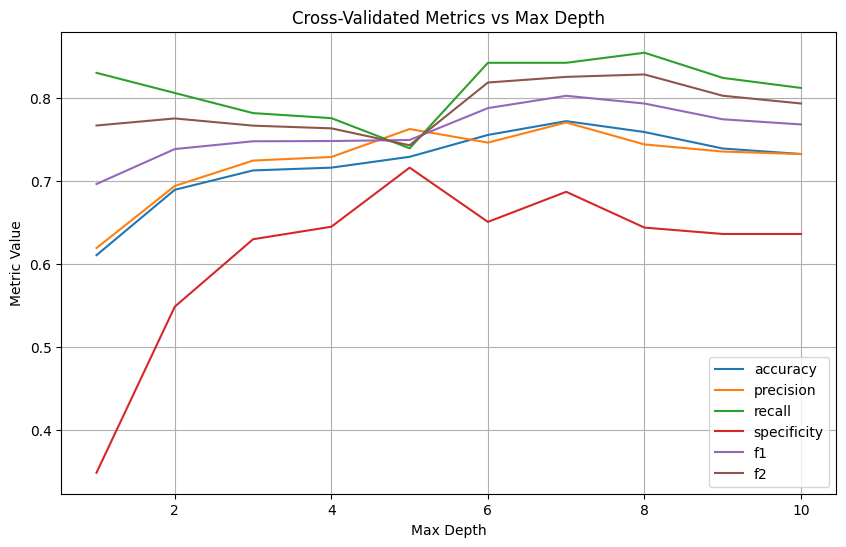

In [17]:
# Sweep max depth from 1 to 10 and evaluate metrics using cross-validation
depths = range(1, 11)
metrics_by_depth = {
    "accuracy": [],
    "precision": [],
    "recall": [],
    "specificity": [],
    "f1": [],
    "f2": []
}

for depth in depths:
    model = DecisionTree(max_depth=depth, min_samples_split=2, criterion="gain_ratio")
    cv_metrics = k_fold_cross_validation(model, X_no_ID, y, k=5)

    # Compute average metrics across folds
    metrics_by_depth["accuracy"].append(np.mean(cv_metrics["accuracy"]))
    metrics_by_depth["precision"].append(np.mean(cv_metrics["precision"]))
    metrics_by_depth["recall"].append(np.mean(cv_metrics["recall"]))
    metrics_by_depth["specificity"].append(np.mean(cv_metrics["specificity"]))
    metrics_by_depth["f1"].append(np.mean(cv_metrics["f1"]))
    metrics_by_depth["f2"].append(np.mean(cv_metrics["f2"]))

# Plot metrics vs max depth
plt.figure(figsize=(10, 6))
for metric, values in metrics_by_depth.items():
    plt.plot(depths, values, label=metric)

plt.title("Cross-Validated Metrics vs Max Depth")
plt.xlabel("Max Depth")
plt.ylabel("Metric Value")
plt.legend()
plt.grid()
plt.show()

In [30]:
model = DecisionTreeClassifier(random_state=42)
print("Performing cross-validation on the entire dataset...")
X = encoded_df.drop(columns=["Has heart disease? (Prediction Target)", "person ID"])
y = encoded_df["Has heart disease? (Prediction Target)"]

start_time = time.time()
cv_metrics = k_fold_cross_validation(model, X, y, k=10)
elapsed_time = time.time() - start_time

avg_metrics = {metric: np.mean(scores) for metric, scores in cv_metrics.items()}
std_metrics = {metric: np.std(scores) for metric, scores in cv_metrics.items()}
avg_metrics["time (s)"] = elapsed_time / 10
std_metrics["time (s)"] = 0

metrics_df = pd.DataFrame({
    "Metric": avg_metrics.keys(),
    "Mean": [f"{value:.4f}" for value in avg_metrics.values()],
    "Std": [f"{std_metrics[metric]:.4f}" for metric in avg_metrics.keys()]
})

metrics_df

Performing cross-validation on the entire dataset...


,Metric,Mean,Std
0,accuracy,0.6989,0.0743
1,precision,0.7330,0.0832
2,recall,0.7081,0.0873
3,specificity,0.6890,0.1012
4,f1,0.7179,0.0733
5,f2,0.7115,0.0796
6,time (s),0.0073,0.0000


In [31]:
model = DecisionTree(max_depth=8, criterion="gain_ratio")

In [32]:
print("Performing cross-validation on the entire dataset...")
X = encoded_df.drop(columns=["Has heart disease? (Prediction Target)", "person ID"])
y = encoded_df["Has heart disease? (Prediction Target)"]

start_time = time.time()
cv_metrics = k_fold_cross_validation(model, X, y, k=10)
elapsed_time = time.time() - start_time

avg_metrics = {metric: np.mean(scores) for metric, scores in cv_metrics.items()}
std_metrics = {metric: np.std(scores) for metric, scores in cv_metrics.items()}
avg_metrics["time (s)"] = elapsed_time / 10
std_metrics["time (s)"] = 0

metrics_df = pd.DataFrame({
    "Metric": avg_metrics.keys(),
    "Mean": [f"{value:.4f}" for value in avg_metrics.values()],
    "Std": [f"{std_metrics[metric]:.4f}" for metric in avg_metrics.keys()]
})

metrics_df

Performing cross-validation on the entire dataset...


,Metric,Mean,Std
0,accuracy,0.7387,0.0835
1,precision,0.7309,0.0802
2,recall,0.8283,0.1408
3,specificity,0.6297,0.1249
4,f1,0.7711,0.0856
5,f2,0.8029,0.1133
6,time (s),0.2089,0.0000


In [22]:
print("Calculating SHAP values...")
shap_values, expected_value = model.shap_values(X_test)

Calculating SHAP values...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [01:59<00:00,  1.96s/it]


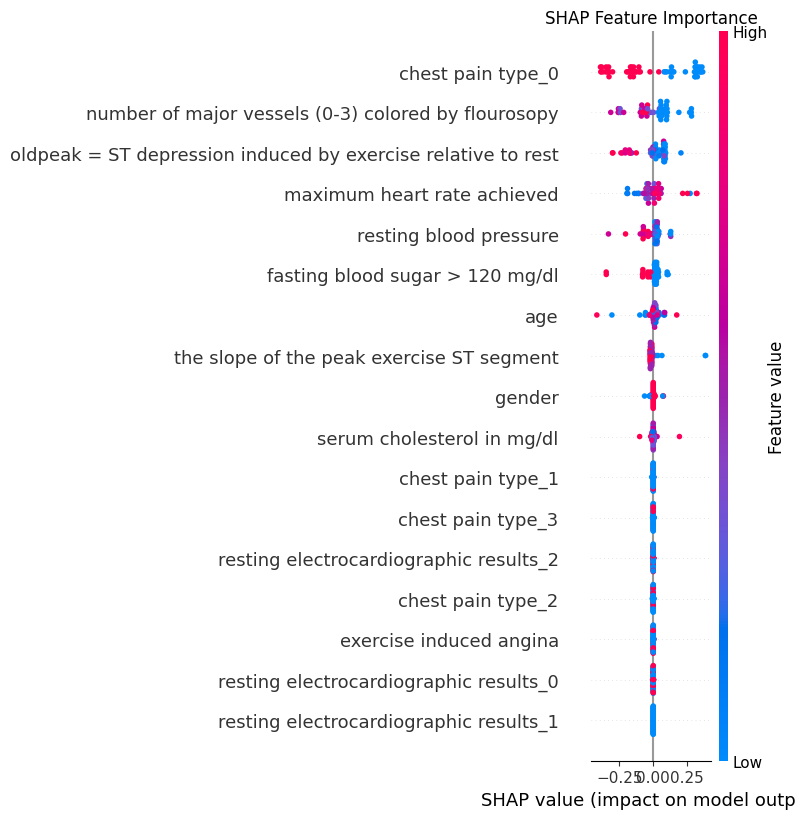

In [23]:
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, show=False)
plt.title("SHAP Feature Importance")
plt.tight_layout()
plt.savefig('shap_summary.png')
plt.show()

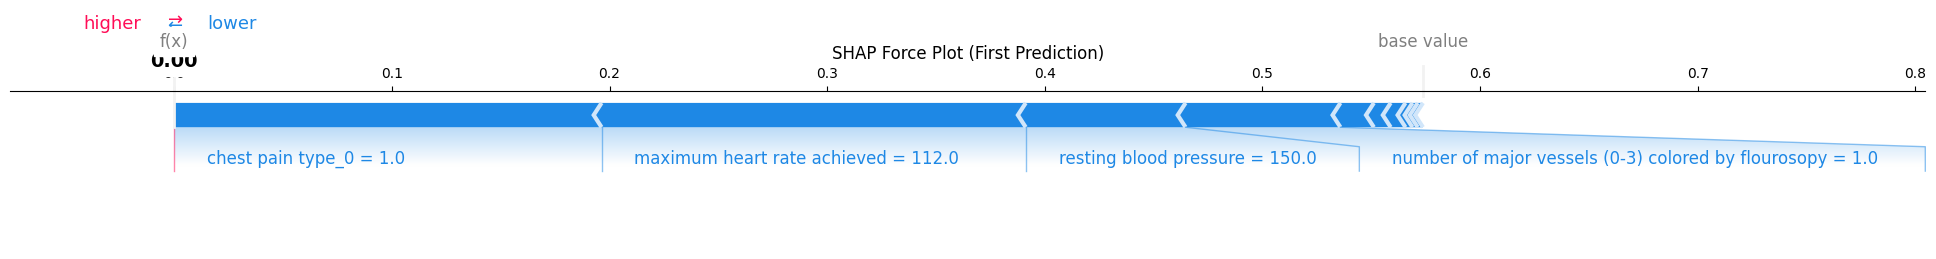

In [24]:
shap.force_plot(
    expected_value, 
    shap_values[0], 
    X_test.iloc[0],
    matplotlib=True,
    show=False
)
plt.title("SHAP Force Plot (First Prediction)")
plt.tight_layout()
plt.savefig('shap_force_plot.png')
plt.show()